# 1. Import the data

In [1]:
import pandas as pd
data = pd.read_csv('BA.csv', index_col=0)
data.index = pd.to_datetime(data.index)
data.tail()

,Open,High,Low,Close,Volume,Dividend,Split,Adj_Open,Adj_High,Adj_Low,Adj_Close,Adj_Volume
Date,,,,,,,,,,,,
2018-04-09,332.25,334.88,322.05,322.48,4931728.0,0.0,1.0,330.606910,333.223904,320.457353,320.885226,4931728.0
2018-04-10,331.35,336.69,329.55,334.83,5616231.0,0.0,1.0,329.711361,335.024953,327.920263,333.174151,5616231.0
2018-04-11,331.60,337.57,326.31,327.36,4566253.0,0.0,1.0,329.960125,335.900601,324.696286,325.741093,4566253.0
2018-04-12,331.98,338.35,330.46,337.48,4318083.0,0.0,1.0,330.338246,336.676744,328.825763,335.811046,4318083.0
2018-04-13,338.99,339.67,326.60,329.28,4730972.0,0.0,1.0,337.313579,337.990216,324.984852,327.651598,4730972.0


# 2. Define predictor variables and a target variables

In [2]:
# Returns
data['ret1'] = data['Adj_Close'].pct_change()
data['ret5'] = data.ret1.rolling(5).sum()

# Standard Deviation
data['std5'] = data.ret1.rolling(5).std()

# Volume by ADV20
data['volume_by_adv20'] = data['Adj_Volume']/data.Adj_Volume.rolling(20).mean()

# High - low
data['H-L'] = data['Adj_High'] - data['Adj_Low']

# Open - Close
data['O-C'] = data['Adj_Close'] - data['Adj_Open']

In [3]:
# Future returns
data['retFut1'] = data.ret1.shift(-1)

In [4]:
# Define predictor variables (X) and a target variable (y)
import numpy as np
data = data.dropna()
predictor_list = ['H-L', 'O-C', 'ret5', 'std5', 'volume_by_adv20']
X = data[predictor_list]

y = np.where(data.retFut1 > 0.0, 1, 0)
X.shape, y.shape

((2569, 5), (2569,))

# 3. Split the data into train and test dataset

In [5]:
# Split the data into train and test dataset
from sklearn.model_selection import train_test_split

train_length = int(len(data)*0.80)

X_train = X[:train_length]
X_test = X[train_length:]

y_train = y[:train_length]
y_test = y[train_length:]

# 4. Scale the data

In [6]:
from sklearn.preprocessing import StandardScaler
scaler = StandardScaler()

# Create the scaler model using train data
scaler.fit(X_train)

# Transform the training and test data using the scaler model created above
X_train = scaler.transform(X_train)
X_test = scaler.transform(X_test)

# 5. Create a neural network model

In [7]:
# Import the MLPClassifier
from sklearn.neural_network import MLPClassifier
# Uncomment below line to see details of MLPClassifier
# help(MLPClassifier)

In [8]:
# seed is initialized to 42
seed = 42
# Create the MLPClassifier model
mlp = MLPClassifier(activation='logistic', hidden_layer_sizes=(
    5), random_state=seed, solver='sgd')

## 5.1 Training the model

In [9]:
# Fit the model on train dataset
mlp.fit(X_train, y_train)

MLPClassifier(activation='logistic', hidden_layer_sizes=5, random_state=42,
              solver='sgd')

## 5.2 Predict using the neural network

In [10]:
data['predicted_signal'] = mlp.predict(X)
data['strategy_returns_nn'] = data.retFut1 * data.predicted_signal
data.tail()

,Open,High,Low,Close,Volume,Dividend,Split,Adj_Open,Adj_High,Adj_Low,...,Adj_Volume,ret1,ret5,std5,volume_by_adv20,H-L,O-C,retFut1,predicted_signal,strategy_returns_nn
Date,,,,,,,,,,,,,,,,,,,,,
2018-04-06,330.61,334.59,322.21,326.12,5711469.0,0.0,1.0,328.975021,332.935338,320.616562,...,5711469.0,-0.030559,-0.004014,0.026146,0.895242,12.318777,-4.467795,-0.011162,0,-0.0
2018-04-09,332.25,334.88,322.05,322.48,4931728.0,0.0,1.0,330.606910,333.223904,320.457353,...,4931728.0,-0.011162,0.001416,0.025429,0.764671,12.766551,-9.721684,0.038297,0,0.0
2018-04-10,331.35,336.69,329.55,334.83,5616231.0,0.0,1.0,329.711361,335.024953,327.920263,...,5616231.0,0.038297,0.013723,0.028899,0.873983,7.104690,3.462790,-0.022310,0,-0.0
2018-04-11,331.60,337.57,326.31,327.36,4566253.0,0.0,1.0,329.960125,335.900601,324.696286,...,4566253.0,-0.022310,0.001631,0.030704,0.715461,11.204315,-4.219032,0.030914,0,0.0
2018-04-12,331.98,338.35,330.46,337.48,4318083.0,0.0,1.0,330.338246,336.676744,328.825763,...,4318083.0,0.030914,0.005181,0.031516,0.726307,7.850981,5.472801,-0.024298,0,-0.0


# 6. Performance of the neural network

## 6.1 Sharpe Ratio

In [11]:
# The below function returns the Sharpe ratio for the excess returns (Strategy returns - Risk free rate) passed to it.
def annualized_sharpe_ratio(returns, N=252):
    return np.sqrt(N) * returns.mean() / returns.std()

In [12]:
# Train dataset
data['excess_daily_strategy_return'] = data.strategy_returns_nn - 0.05/252
sharpe_train_nn = annualized_sharpe_ratio(
    data.excess_daily_strategy_return.iloc[:train_length])

# Test dataset
sharpe_test_nn = annualized_sharpe_ratio(
    data.excess_daily_strategy_return.iloc[train_length:])

## 6.2 Strategy CAGR

In [13]:
def CAGR(returns):
    cumulative_returns = (returns+1).cumprod().iloc[-1]
    period_in_days = len(returns)
    return 100*((cumulative_returns)**(252.0/period_in_days)-1)

In [14]:
# Train dataset
ret_train_nn = CAGR(data.strategy_returns_nn.iloc[:train_length])

# Test dataset
ret_test_nn = CAGR(data.strategy_returns_nn.iloc[train_length:])

## 6.3 Plot cumulative returns in train dataset

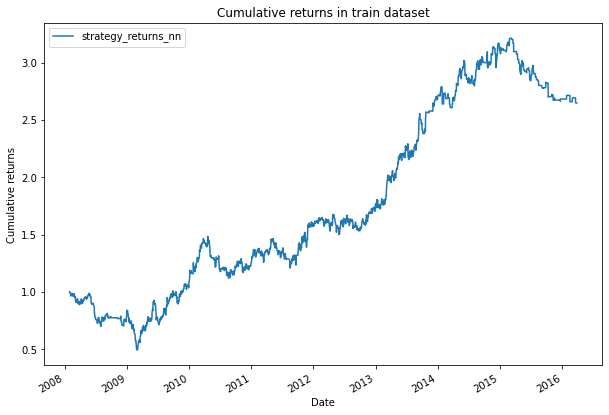

In [15]:
import matplotlib.pyplot as plt
import seaborn
plt.title("Cumulative returns in train dataset")

# Plotting the cumulative returns for neural network in train dataset
(data.strategy_returns_nn[:train_length]+1).cumprod().plot(figsize=(10,7))
plt.ylabel('Cumulative returns')
# Show the legend
plt.legend()

# Show the graph
plt.show()

## 6.4 Plot cumulative returns in test dataset

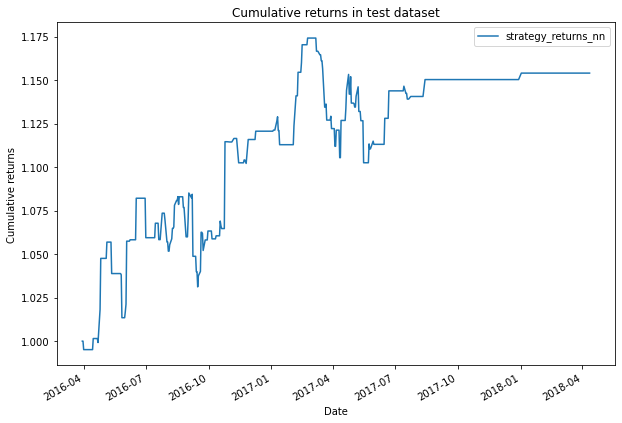

In [16]:
# Plotting the cumulative returns for neural network in test dataset
plt.title("Cumulative returns in test dataset")
(data.strategy_returns_nn[train_length:]+1).cumprod().plot(figsize=(10, 7))
plt.ylabel('Cumulative returns')
# Show the legend
plt.legend()

# Show the graph
plt.show()

## 6.5 Strategy Results

In [19]:
pip install tabulate

Note: you may need to restart the kernel to use updated packages.


In [20]:
from tabulate import tabulate

print(tabulate(
    [
        ['CAGR', ret_train_nn, ret_test_nn],
        ['Sharpe Ratio', sharpe_train_nn, sharpe_test_nn],
    ],
    headers=['Train', 'Test'],
    tablefmt='orgtbl'))

|              |     Train |     Test |
|--------------+-----------+----------|
| CAGR         | 12.6792   | 7.2788   |
| Sharpe Ratio |  0.420195 | 0.285062 |


## 6.6 Accuracy of the neural network classifier

In [21]:
from sklearn.metrics import classification_report
print(classification_report(y_test, mlp.predict(X_test)))

              precision    recall  f1-score   support

           0       0.44      0.57      0.50       216
           1       0.61      0.48      0.54       298

    accuracy                           0.52       514
   macro avg       0.53      0.53      0.52       514
weighted avg       0.54      0.52      0.52       514

